In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

import pandas as pd
import io
import timeit

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [8]:
%store data_ready

Stored 'data_ready' (DataFrame)


In [9]:
%store -r data_ready

In [4]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


In [5]:
import pandas as pd
import io
data_ready = pd.read_csv(io.BytesIO(uploaded['preprocessed_data.csv']))

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [24]:
select_data = data_ready[data_ready['category'].isin(cat_index[0:3])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


In [25]:
def create_nn_model(dropout_rate=0.0, lam_l2=1e-3, learning_rate=1e-3, nlayers=5):
    # create model
    model = Sequential(name="Neural_network")
    for i in range(nlayers):
        model.add(layers.Dense(8*(nlayers-i), kernel_regularizer=l2(lam_l2), bias_regularizer=l2(lam_l2), input_dim=input_dim, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [33]:
# define the grid search parameters
#batch_size
cand_bs = [512, 2048, 4096][2:3]
#dropout rate
cand_dr = [0, 0.15, 0.3][0:1]
#regularization
cand_l2 = [0, 1e-3, 1][0:1]
#learning rate
cand_lr = [1e-4, 1e-3, 1e-2][2:3]
#layers number
cand_ln = [10, 5, 1][2:3]

model = KerasClassifier(build_fn=create_nn_model, epochs=20, verbose=0)

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln, learning_rate=cand_lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


Tune hyperparameters through cross-validation

In [34]:
grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Best: 0.949672 using {'batch_size': 4096, 'dropout_rate': 0, 'lam_l2': 0, 'learning_rate': 0.01, 'nlayers': 1}


In [ ]:
cv_results = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')
nn_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(nn_cv_results0.columns.values)
nn_cv_results0 = nn_cv_results0[clist[-2:] + clist[:-2]]
%store nn_cv_results0
nn_cv_results0

Stored 'nn_cv_results0' (DataFrame)


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_dropout_rate,param_lam_l2,param_learning_rate,param_nlayers
rank_test_score,,,,,,,,,
1,0.949328,0.000889,84.785579,1.89908,1024,0.15,0.001,0.001,5


Summarizing results

Training the best model on the whole training set

In [ ]:
clear_session()

model = create_nn_model(dropout_rate=0.3, lam_l2=1e-3, learning_rate=1e-3, nlayers=5)
model.summary()

Model: "Neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1868760   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1312      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 16)             

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=5, verbose=True, validation_data=(X_test, dummy_y_test),
                    batch_size=4096)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


27/27 [==============================] - 4s 57ms/step - loss: 1.1517 - accuracy: 0.5664 - val_loss: 1.0078 - val_accuracy: 0.6826
Epoch 2/5
27/27 [==============================] - 1s 43ms/step - loss: 0.9610 - accuracy: 0.6460 - val_loss: 0.8050 - val_accuracy: 0.6971
Epoch 3/5
27/27 [==============================] - 2s 44ms/step - loss: 0.8235 - accuracy: 0.6712 - val_loss: 0.6331 - val_accuracy: 0.7210
Epoch 4/5
27/27 [==============================] - 1s 43ms/step - loss: 0.6899 - accuracy: 0.7286 - val_loss: 0.5140 - val_accuracy: 0.9252
Epoch 5/5
27/27 [==============================] - 2s 44ms/step - loss: 0.6059 - accuracy: 0.8197 - val_loss: 0.4743 - val_accuracy: 0.9414


In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9506
Testing Accuracy:  0.9414


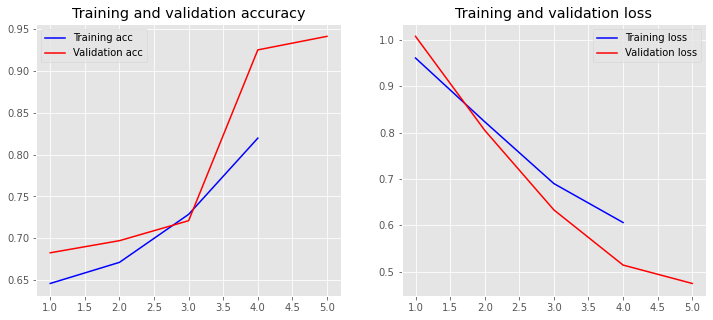

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [ ]:
test_predicted_prob = model.predict(X_test)
test_predicted_classes = test_predicted_prob.argmax(1)

In [ ]:
print("Each row corresponds to a true class, each columns corresponds to a predicted class.")
print("\n")
print(confusion_matrix(encoded_y_test, test_predicted_classes, normalize = 'true'))

Each row corresponds to a true class, each columns corresponds to a predicted class.


[[0.9446695  0.04762375 0.00770675]
 [0.04396309 0.93168418 0.02435273]
 [0.01600269 0.0341316  0.94986571]]
